# Perbandingan Kinerja Moving Average, Exponential Smoothing, dan Variannya untuk Forecasting Penjualan Mingguan di Toko Ritel
Kode oleh: Muhammad Naufal Faza

Dokumentasi oleh: Michael Harditya

## Memuat data
Data diambil dari https://www.kaggle.com/datasets/manjeetsingh/retaildataset, berisi data penjualan usaha ritel yang memiliki beberapa toko dan cabang. Beberapa data yang dimilikinya adalah:
- `Store`: Nomor toko.
- `Dept`: Nomor departemen dalam toko.
- `Date`: Tanggal penjualan (mingguan).
- `Weekly_Sales`: Total penjualan mingguan untuk departemen tertentu di toko tertentu.
- `IsHoliday`: Indikator apakah minggu tersebut merupakan minggu liburan.

Data yang digunakan dalam percobaan adalah data dari salah satu `store` yang ada pada data, sehingga percobaan dapat merepresentasikan lebih baik terhadap satu toko usaha ritel.

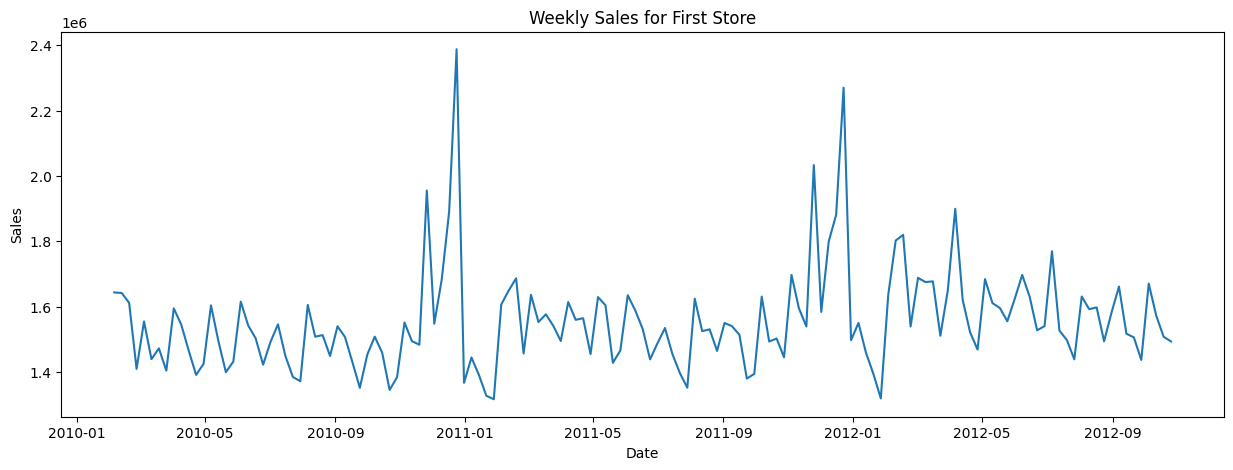

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox
import warnings

warnings.filterwarnings('ignore')

# Load and preprocess data
df = pd.read_csv('data/sales data-set.csv')
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# Select the first store
first_store = df['Store'].unique()[0]
store_data = df[df['Store'] == first_store]

# Aggregate sales data for the first store
store_sales = store_data.groupby('Date')['Weekly_Sales'].sum().reset_index()
store_sales.set_index('Date', inplace=True)

# Initial Data Visualization
plt.figure(figsize=(15, 5))
plt.plot(store_sales.index, store_sales['Weekly_Sales'])
plt.title('Weekly Sales for First Store')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

## Dekomposisi
Data kemudian didekomposisikan menggunakan metode *additive* untuk memisahkan komponen tren, musiman, dan residual pada data penjualan mingguan.

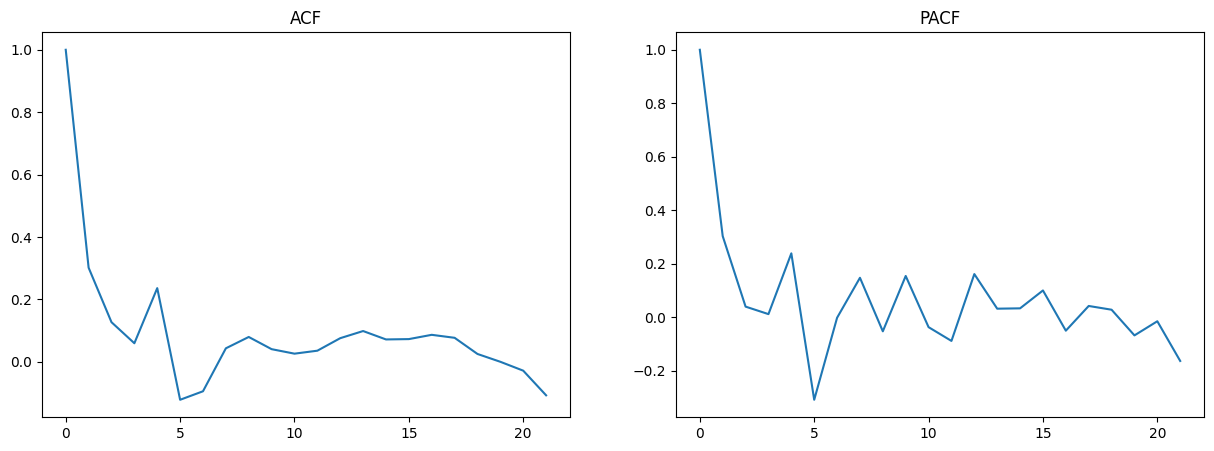

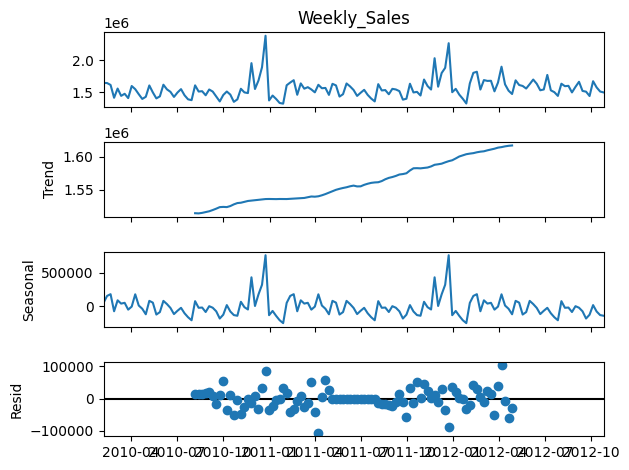

In [15]:
# ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
acf_values = acf(store_sales['Weekly_Sales'])
pacf_values = pacf(store_sales['Weekly_Sales'])
ax1.plot(acf_values)
ax1.set_title('ACF')
ax2.plot(pacf_values)
ax2.set_title('PACF')
plt.show()

# Seasonal Decomposition
decomposition = seasonal_decompose(store_sales['Weekly_Sales'], model='additive', period=52)
decomposition.plot()
plt.show()

## Uji Stasioner
Pengujian dilakukan menggunakan Augmented Dickey-Fuller (ADF) untuk menguji stasioneritas data penjualan mingguan. Pengujian dilakukan untuk memutuskan apakah perlu melakukan *differencing* terlebih dahulu sebelum melakukan *forecasting*.

Didapati nilai statistik uji `-5.10` dan p-value `1.38×10^(-5)` (kurang dari `0.05`). Lag yang digunakan dalam uji ADF adalah `4`, dengan jumlah observasi `138`. **Karena p-value kurang dari tingkat signifikansi 0.05, hipotesis nol bahwa data tidak stasioner ditolak. Dengan demikian, data penjualan mingguan dapat langsung digunakan untuk forecasting tanpa perlu dilakukan differencing.**

In [17]:
# Function to check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(result)
    return result[1] <= 0.05

# Function to calculate performance metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    me = np.mean(actual - predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mpe = np.mean((actual - predicted) / actual) * 100
    return {'RMSE': rmse, 'MAE': mae, 'ME': me, 'MAPE': mape, 'MPE': mpe}

# Function to calculate performance metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    me = np.mean(actual - predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mpe = np.mean((actual - predicted) / actual) * 100
    return {'RMSE': rmse, 'MAE': mae, 'ME': me, 'MAPE': mape, 'MPE': mpe}

# Function for Moving Average forecasting
def ma_forecast(train, test, window):
    history = list(train)
    predictions = []
    for t in range(len(test)):
        yhat = np.mean(history[-window:])
        predictions.append(yhat)
        history.append(test.iloc[t])
    return predictions

# Function for Simple Exponential Smoothing forecasting
def ses_forecast(train, test, alpha):
    model = SimpleExpSmoothing(train)
    fit = model.fit(smoothing_level=alpha, optimized=False)
    predictions = fit.forecast(len(test))
    return predictions

# Function for Double Exponential Smoothing forecasting
def des_forecast(train, test, smoothing_level, smoothing_slope):
    model = ExponentialSmoothing(train, trend='add', seasonal=None)
    fit = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, optimized=False)
    predictions = fit.forecast(len(test))
    return predictions

# Function for Triple Exponential Smoothing forecasting
def tes_forecast(train, test, seasonal_periods, smoothing_level, smoothing_slope, smoothing_seasonal):
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    fit = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, smoothing_seasonal=smoothing_seasonal, optimized=False)
    predictions = fit.forecast(len(test))
    return predictions

In [18]:
# Check stationarity and apply transformation if needed
if check_stationarity(store_sales['Weekly_Sales']):
    data_to_use = store_sales['Weekly_Sales']
else:
    # First-order differencing
    data_to_use = store_sales['Weekly_Sales'].diff().dropna()
    if check_stationarity(data_to_use):
        print("Data transformed to achieve stationarity using first-order differencing.")
    else:
        # Second-order differencing
        data_to_use = data_to_use.diff().dropna()
        if check_stationarity(data_to_use):
            print("Data transformed to achieve stationarity using second-order differencing.")
        else:
             # Seasonal Differencing (Example: Weekly data with yearly seasonality)
            data_to_use = store_sales['Weekly_Sales'].diff(52).dropna()
            if check_stationarity(data_to_use):
                print("Data transformed to achieve stationarity using seasonal differencing.")
            else:
                print("Warning: Data remains non-stationary after differencing.")

(np.float64(-5.102186145192287), np.float64(1.3877788330759535e-05), 4, 138, {'1%': np.float64(-3.47864788917503), '5%': np.float64(-2.882721765644168), '10%': np.float64(-2.578065326612056)}, np.float64(3412.7325502876756))


## Evaluasi Forecast
Evaluasi dilakukan dengan memecah data menjadi *train set* dan *test set*, dimana *train set* digunakan untuk melakukan prediksi nilai berikutnya, dan *test set* dibandingkan sebagai *ground truth* dari hasil prediksi. Keduanya dihitung nilai evaluasinya menggunakan `RMSE`, `MAE`, `ME`, `MAPE`, dan `MPE`.
Kesimpulan dan analisis disampaikan pada paper.

In [10]:


# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Dictionary to store results
results = {'MA': {}, 'SES': {}, 'DES': {}, 'TES': {}}

for train_index, test_index in tscv.split(data_to_use):
    train, test = data_to_use.iloc[train_index], data_to_use.iloc[test_index]
    
    # Moving Average
    for window in range(1, 53):
        predictions = ma_forecast(train, test, window)
        metrics = calculate_metrics(test, predictions)
        results['MA'].setdefault(window, []).append(metrics['RMSE'])
    
    # Simple Exponential Smoothing
    for alpha in np.arange(0.01, 1.0, 0.01):
        predictions = ses_forecast(train, test, alpha)
        metrics = calculate_metrics(test, predictions)
        results['SES'].setdefault(alpha, []).append(metrics['RMSE'])
    
    # Double Exponential Smoothing
    for alpha in np.arange(0.1, 1.0, 0.1):
        for beta in np.arange(0.1, 1.0, 0.1):
            predictions = des_forecast(train, test, alpha, beta)
            metrics = calculate_metrics(test, predictions)
            results['DES'].setdefault((alpha, beta), []).append(metrics['RMSE'])
    
    # Triple Exponential Smoothing
    
    seasonal_periods = min(52, len(train) // 2)  # Adjust seasonal_periods based on data size
    for alpha in np.arange(0.1, 1.0, 0.2):
        for beta in np.arange(0.1, 1.0, 0.2):
            for gamma in np.arange(0.1, 1.0, 0.2):
                predictions = tes_forecast(train, test, seasonal_periods, alpha, beta, gamma)
                if predictions is not None:  # Only calculate metrics if predictions were successful
                    metrics = calculate_metrics(test, predictions)
                    results['TES'].setdefault((alpha, beta, gamma), []).append(metrics['RMSE'])

# Find best parameters
best_params = {}
for method in results:
    best_params[method] = min(results[method], key=lambda k: np.mean(results[method][k]))

# Final forecasting with best parameters
train, test = train_test_split(data_to_use, test_size=0.2, shuffle=False)

final_predictions = {
    'MA': ma_forecast(train, test, best_params['MA']),
    'SES': ses_forecast(train, test, best_params['SES']),
    'DES': des_forecast(train, test, *best_params['DES']),
    'TES': tes_forecast(train, test, seasonal_periods, *best_params['TES'])
}
if 'TES' in best_params:
    tes_pred = tes_forecast(train, test, seasonal_periods, *best_params['TES'])
    if tes_pred is not None:
        final_predictions['TES'] = tes_pred

# Calculate final metrics
final_metrics = {method: calculate_metrics(test, pred) for method, pred in final_predictions.items()}


MA Best Parameters: 17
MA Metrics: {'RMSE': np.float64(85165.73016117307), 'MAE': np.float64(70284.89529411768), 'ME': np.float64(-33684.08559837731), 'MAPE': np.float64(4.542582558393668), 'MPE': np.float64(-2.3823856415033426)}
SES Best Parameters: 0.19
SES Metrics: {'RMSE': np.float64(136544.5558203248), 'MAE': np.float64(118060.81458677398), 'ME': np.float64(-110896.18972635223), 'MAPE': np.float64(7.735190281419251), 'MPE': np.float64(-7.327547407726008)}
DES Best Parameters: (np.float64(0.2), np.float64(0.1))
DES Metrics: {'RMSE': np.float64(211832.5952356104), 'MAE': np.float64(189891.74488992215), 'ME': np.float64(-188601.5940829774), 'MAPE': np.float64(12.387655638207852), 'MPE': np.float64(-12.314759755818043)}
TES Best Parameters: (np.float64(0.30000000000000004), np.float64(0.1), np.float64(0.30000000000000004))
TES Metrics: {'RMSE': np.float64(199537.79663256847), 'MAE': np.float64(184297.84092125454), 'ME': np.float64(-184297.84092125454), 'MAPE': np.float64(11.8702406087

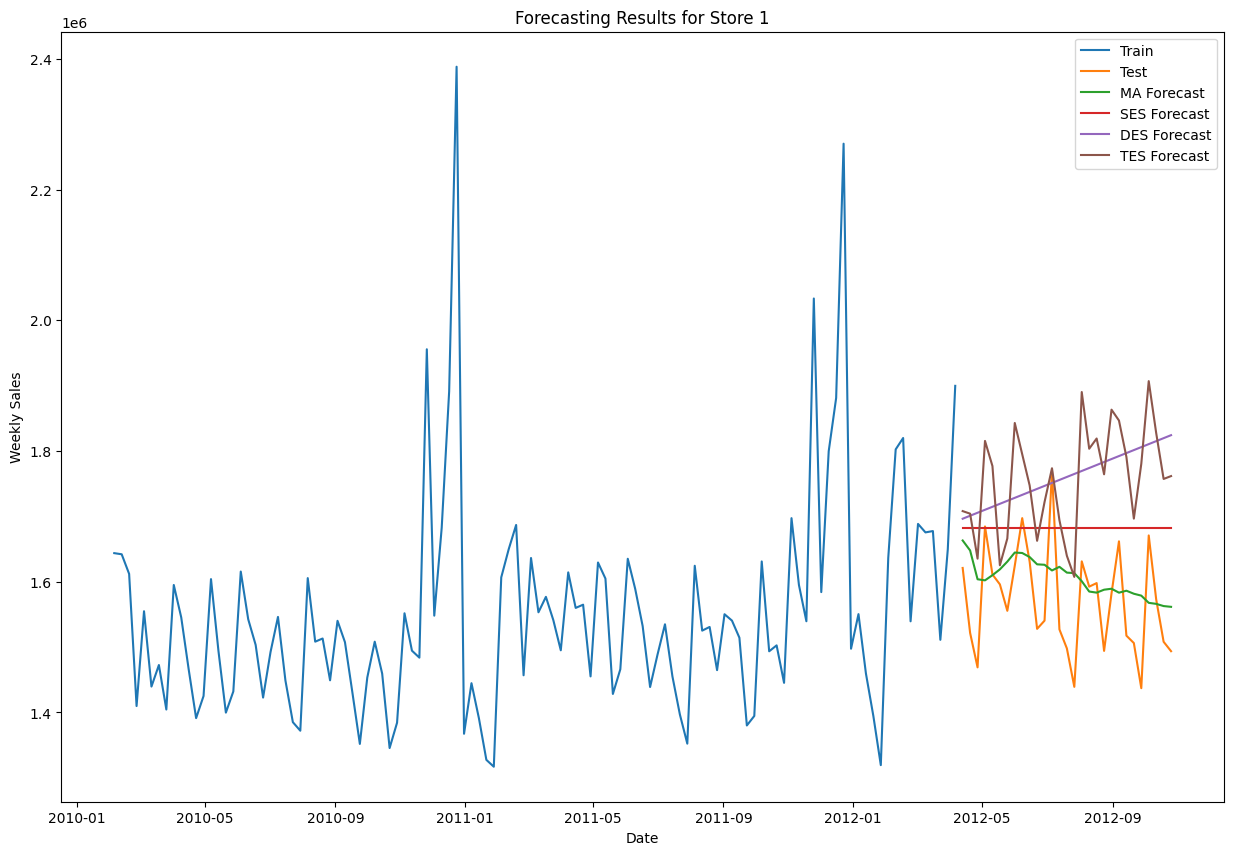

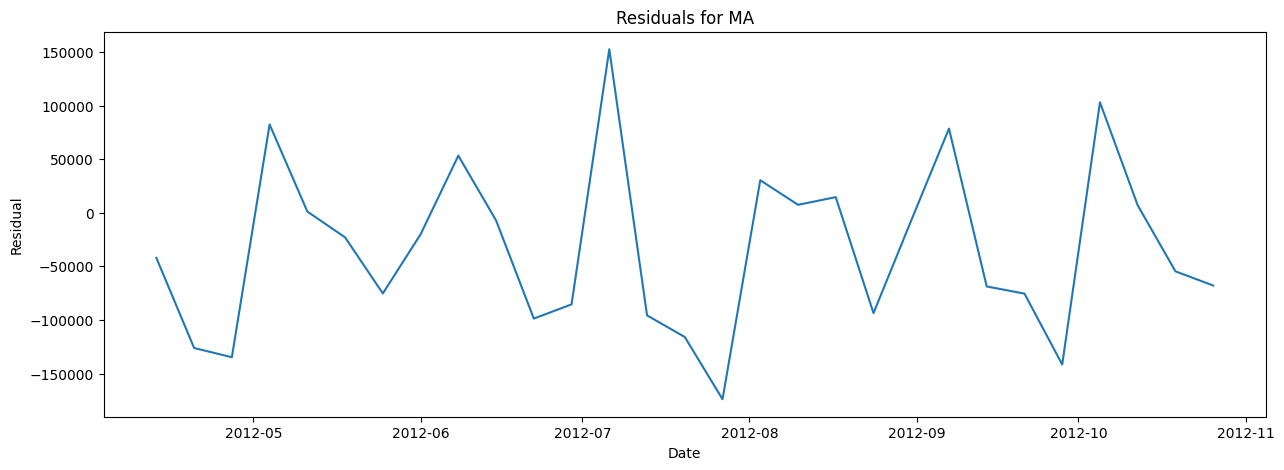

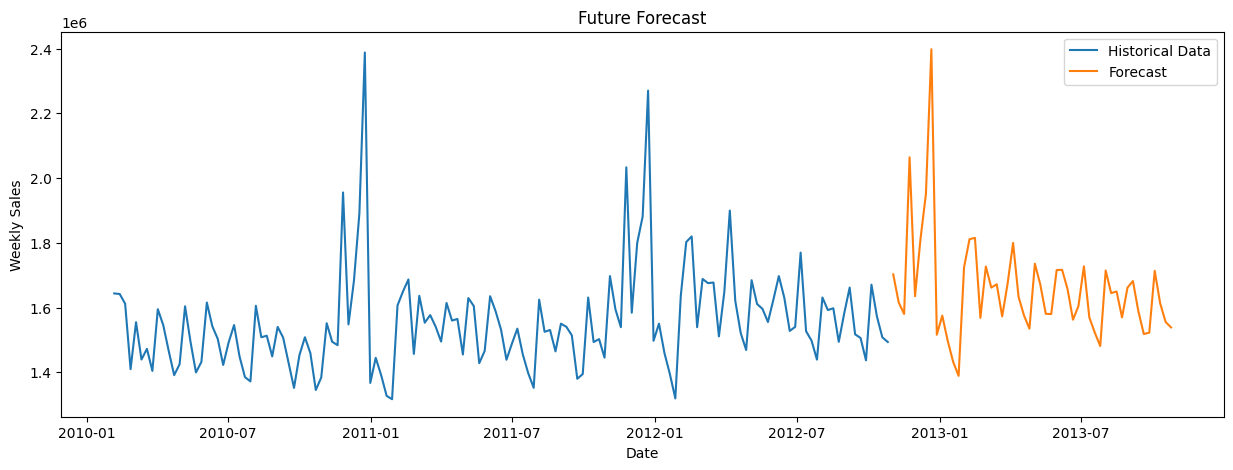

In [11]:
# Print results
for method in final_metrics:
    print(f"{method} Best Parameters: {best_params[method]}")
    print(f"{method} Metrics: {final_metrics[method]}")

# Plot results
plt.figure(figsize=(15, 10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
for method, pred in final_predictions.items():
    plt.plot(test.index, pred, label=f'{method} Forecast')
plt.title(f'Forecasting Results for Store {first_store}')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

# Residual analysis for best model
best_method = min(final_metrics, key=lambda k: final_metrics[k]['RMSE'])
residuals = test - final_predictions[best_method]

plt.figure(figsize=(15, 5))
plt.plot(test.index, residuals)
plt.title(f'Residuals for {best_method}')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()

# Future forecasting
best_model = ExponentialSmoothing(data_to_use, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
best_fit = best_model.fit(*best_params['TES'])
future_forecast = best_fit.forecast(steps=52)  # Forecast next 52 weeks

plt.figure(figsize=(15, 5))
plt.plot(data_to_use.index, data_to_use, label='Historical Data')
plt.plot(future_forecast.index, future_forecast, label='Forecast')
plt.title('Future Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()

## Percobaan 52 Minggu Ke Depan
Percobaan prediksi kembali dilakukan untuk 52 minggu diluar waktu dataset, untuk melihat hasil prediksi yang dihasilkan oleh data. Kesimpulan dan analisis dapat dibaca pada paper.

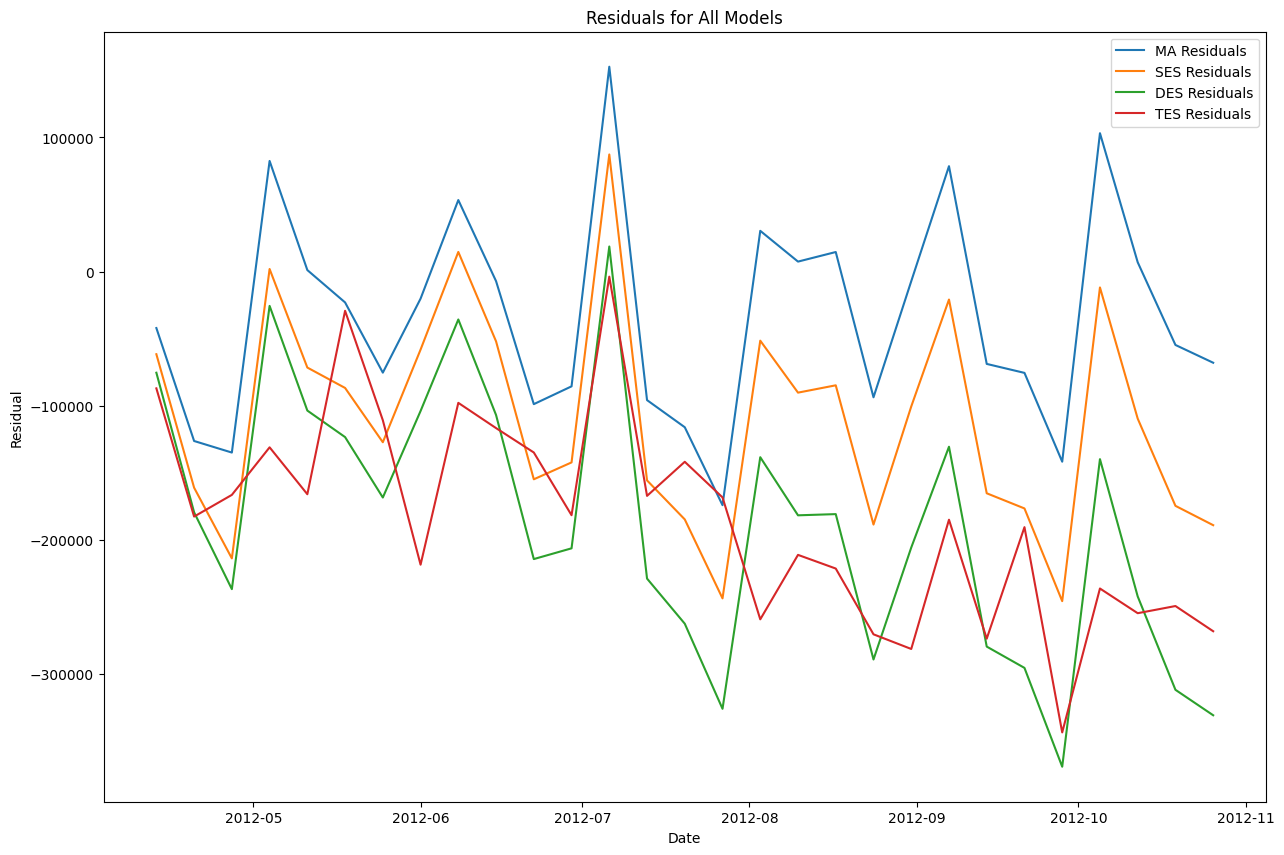

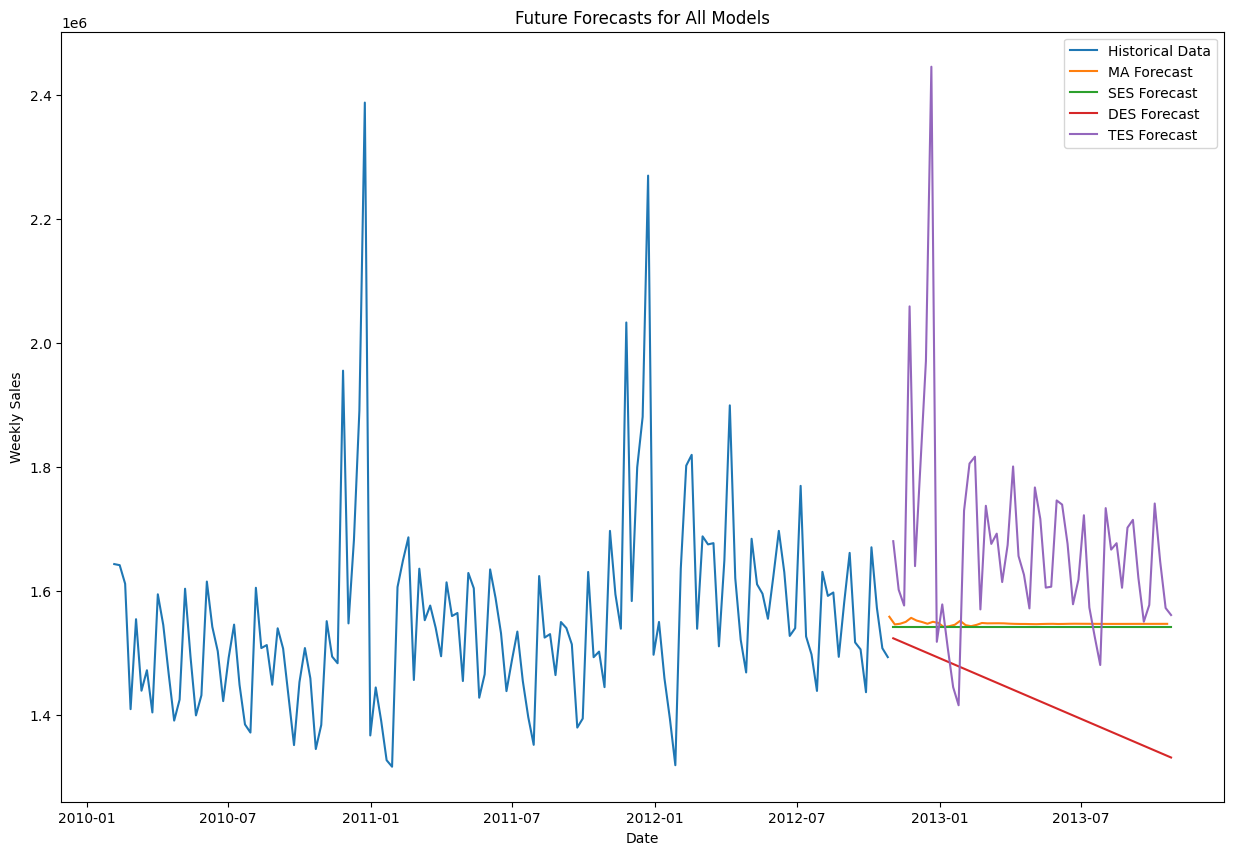

In [13]:
# Residual analysis for all models
plt.figure(figsize=(15, 10))
for method, pred in final_predictions.items():
    residuals = test - pred
    plt.plot(test.index, residuals, label=f'{method} Residuals')
plt.title('Residuals for All Models')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()

# Future forecasting for all models
future_index = pd.date_range(start=data_to_use.index[-1] + pd.Timedelta(days=1), periods=52, freq='W')

future_forecasts = {}

# MA future forecast
ma_history = list(data_to_use)
ma_future = []
for _ in range(52):
    yhat = np.mean(ma_history[-best_params['MA']:])
    ma_future.append(yhat)
    ma_history.append(yhat)
future_forecasts['MA'] = pd.Series(ma_future, index=future_index)

# SES future forecast
ses_model = SimpleExpSmoothing(data_to_use)
ses_fit = ses_model.fit(smoothing_level=best_params['SES'], optimized=False)
future_forecasts['SES'] = ses_fit.forecast(52)

# DES future forecast
des_model = ExponentialSmoothing(data_to_use, trend='add')
des_fit = des_model.fit(smoothing_level=best_params['DES'][0], smoothing_slope=best_params['DES'][1], optimized=False)
future_forecasts['DES'] = des_fit.forecast(52)

# TES future forecast (if available)
if 'TES' in best_params:
    try:
        tes_model = ExponentialSmoothing(data_to_use, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        tes_fit = tes_model.fit(smoothing_level=best_params['TES'][0], smoothing_slope=best_params['TES'][1], 
                                smoothing_seasonal=best_params['TES'][2], optimized=False)
        future_forecasts['TES'] = tes_fit.forecast(52)
    except ValueError as e:
        print(f"Error in TES future forecasting: {e}")

# Plot future forecasts
plt.figure(figsize=(15, 10))
plt.plot(data_to_use.index, data_to_use, label='Historical Data')
for method, forecast in future_forecasts.items():
    plt.plot(forecast.index, forecast, label=f'{method} Forecast')
plt.title('Future Forecasts for All Models')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.show()